In [3]:
# Import numpy
import numpy as np
from glob import glob
from astropy.io import fits, ascii

# Importing plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

# Use seaborn plotting style defaults
#import seaborn as sns; sns.set()

# Import Astropy things we need
from astropy.io import ascii

import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table

from scipy.ndimage import median_filter
from sklearn.neighbors import NearestNeighbors
from glob import glob
import os

In [4]:
def remove_oscan_file(inname, outname, clobber=False):

    tmp_indata = fits.getdata(inname)
    tmp_inhead = fits.getheader(inname)
    tmp_outdata = remove_oscan(tmp_indata)

    tmp_inhead['history'] = 'Removed Overscan'
    
    fits.writeto(outname, tmp_outdata, tmp_inhead, clobber=clobber)
    
def remove_oscan(tmp_indata):
    tmp_indata = tmp_indata.T
    data_origshape = tmp_indata.shape
    
    oscan1x = (1026, 1050); oscan1y = (1025, 2049)
    oscan2x = (1051, 1075); oscan2y = (1025, 2049)
    oscan3x = (1051, 1075); oscan3y = (0, 1024)
    oscan4x = (1026, 1050); oscan4y = (0, 1024)

    rows_to_remove = [1024, 1025]
    n_delrow = len(rows_to_remove)
    cols_to_remove = [0, 1, 2100, 2101] + np.arange(1026, 1076).tolist()
    n_delcol = len(cols_to_remove)
    
    bias1 = median_osreg(tmp_indata, oscan1x, oscan1y)
#     print(bias1)
    bias2 = median_osreg(tmp_indata, oscan2x, oscan2y)
#     print(bias2)
    bias3 = median_osreg(tmp_indata, oscan3x, oscan3y)
#     print(bias3)
    bias4 = median_osreg(tmp_indata, oscan4x, oscan4y)
#     print(bias4)

    
    tmp_outdata = np.zeros((data_origshape[0] - n_delcol, 
                           data_origshape[1] - n_delrow))
    

    tmp_outdata[0:1024,1024:2048] = tmp_indata[2:1026, 1026:2050] - bias1
    tmp_outdata[1024:2048,1024:2048] = tmp_indata[1077:2101, 1026:2050] - bias2
    tmp_outdata[1024:2048,0:1024] = tmp_indata[1077:2101, 0:1024] - bias3
    tmp_outdata[0:1024,0:1024] = tmp_indata[2:1026, 0:1024] - bias4

    return tmp_outdata.T
    
def median_osreg(im, xlims, ylims):
    medval = np.median(im[xlims[0]:xlims[1]+1, ylims[0]:ylims[1]+1])
    return medval 
    

In [11]:
# Remove overscan on target files.
infile_list = glob('*.fits')
for inname in infile_list:
    outname = "os-remove/"+os.path.split(inname)[1]
    remove_oscan_file(inname, outname)

OSError: File 'os-remove/wasp44b_end_i_24.0485.fits' already exists.

In [5]:
# Loop through fits files to get times, DEC, RA. for HAT-P-53b.

#   0 NUMBER                 Running object number                                     
#   1 FLUX_ISO               Isophotal flux                                             [count]
#   2 FLUXERR_ISO            RMS error for isophotal flux                               [count]
#   3 MAG_ISO                Isophotal magnitude                                        [mag]
#   4 MAGERR_ISO             RMS error for isophotal magnitude                          [mag]
#   5 XWIN_IMAGE             Windowed position estimate along x                         [pixel]
#   6 YWIN_IMAGE             Windowed position estimate along y                         [pixel]
#   7 ALPHAWIN_J2000         Windowed right ascension (J2000)                           [deg]
#   8 DELTAWIN_J2000         windowed declination (J2000)                               [deg]

# Coordinates of Star, beginning
#RA = 3.90615
#DEC = -11.93665

# For Reference Star 1:
#RA_ref1 = 3.93338
#DEC_ref1= -11.9410

# For Reference Star 2:
#RA_ref2 = 21.923235
#DEC_ref2= 38.991684

times = []
newTime = [] # Getting the UTC time.
newMag = []
newMag_err = []
magRef1 = []
magRef1_err = []
magRef2 = []
magRef2_err = []
mag = []
mag_err = []

# Number of catalogue.
listNum = np.arange(478,597,1)

for i in listNum:
    data = fits.open('wasp44b_end_i_24.0' + str(i) + ".fits")
    times.append(data[0].header['DATE-OBS'])
      

for i in np.arange(0, len(listNum)-1, 1):    
    tempTime = times[i][11:]
    newTime.append(tempTime)

# Now we want to read the fluxes from the catalogue.

# Choosing stars by Magnitude.

for i in listNum:
    data = np.loadtxt(str(i) + ".cat")
    stars = np.sort(np.array(data[1]).flatten())
    magRef2.append(stars[2])
    magRef1.append(stars[1])
    mag.append(stars[0])

print(stars[0])


-12.0080958


In [16]:
#ascii.read('479.cat')

# Edit these for particular star.
listNum = np.arange(478,597,1)
target_xpix = 885
target_ypix = 1121
flux = 2368040

ref_lc = []
target_lc = []

def find_index(array, xpix, ypix, flux):
    idx1 = (np.abs(array['XWIN_IMAGE']-xpix)).argmin()
    idx2 = (np.abs(array['YWIN_IMAGE']-ypix)).argmin()
    idx3 = (np.abs(array['FLUX_ISO']-flux)).argmin()
    if idx1 == idx2: 
        return idx1
    else:
        return -1

# Get all Ref Stars
for i in listNum:
    data = ascii.read(str(i) + ".cat")
    data.sort('MAG_ISO')
    data.remove_rows(find_index(data, target_xpix, target_ypix, flux))
    # FINISH THIS
    
for i in listNum:
    data = ascii.read(str(i) + ".cat")
    target_lc.append(data[find_index(data, target_xpix, target_ypix, flux)]['MAG_ISO'])

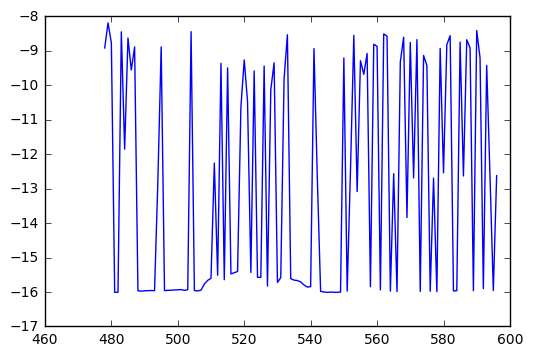

In [17]:
plt.plot(listNum, target_lc)